In [1]:
import numpy as np # Importing relevant modules below
import matplotlib.pyplot as plt
import pandas as pd
import time
from pathlib import Path
from skimage.transform import rotate
from skimage.color import rgb2gray, label2rgb
from scipy.ndimage import rotate
from skimage.filters import threshold_otsu
from skimage.exposure import equalize_adapthist
from skimage.measure import label, regionprops
from skimage.io import imread
from skimage.util import invert

In [2]:
def preProcessImageOriginal(image, display_report_img):

    """
    Original image pre-processing function. Input is the original image, output is the pre-processed image.
    """
    grayscale = rgb2gray(image) 
    grayscale = equalize_adapthist(grayscale, kernel_size=None, clip_limit=0.01, nbins=256) # Contrast enhancement of grayscale image
    
    imageSize = grayscale.shape
    numrows = imageSize[0]
    numcols = imageSize[1]

    if numcols>numrows: # If the number of columns > number of rows then it is landscape
    
        grayscale = rotate(grayscale, -90,reshape=True) # Therefore, rotate to make it portrait

    th = threshold_otsu(grayscale) 
    imgBin = grayscale > th
    imgBinInt = 255*imgBin.astype("uint8") # Convert binary image to integer
    
    labels = label(imgBinInt, connectivity=1) # Label connected regions of integer image

    rP = regionprops(labels) # Use the labels to measure the region properties
    
    propList = [] # List to hold desired properties of each labelled region
    for region in rP:
            
        box = region.bbox
        area = region.area # Accessing desired properties
    
        elem = [box,area]
        propList.append(elem) # Appending to list defined above
    
    propDF = pd.DataFrame(propList, columns=["box","area"]) # Making it into a pandas dataframe
    
    LFT_region_index = np.argmax(propDF.loc[:,"area"]) # Finding the index of the region corresponding to the LFT device, assuming
                                                           # that largest region is LFT device. Do this by accessing the column holding
                                                           # the measured areas to find the index of the region with the largest area 
    
    LFT_box = propDF.loc[LFT_region_index,"box"] # Getting the bounding box coordinates corresponding to that region 
    min_row, min_col, max_row, max_col = LFT_box # Setting values for the min/max row and column from bounding box coordinates

    horizontallength = max_col-min_col
    verticallength = max_row-min_row 

    ratio = verticallength/horizontallength # Computing the aspect ratio of the LFT device as identified in the image 

    if ratio > 4.5 or ratio < 3: # If the aspect ratio doesnt satisfy the range of ratios determined from ImageJ, then either the region 
                                 # doesnt contain the whole device or the region contains too much background, so reject the image
        return 

    rowmidpoint = int((min_row+max_row)/2) 
    colmidpoint = int((min_col+max_col)/2) # Row and column midpoint give the centre coordinate of the LFT device
    
    a = int((max_col-colmidpoint)/7) # Using characteristic length ratios to get find values that will be used for cropping the image to
    l = int((max_row-rowmidpoint)/16) # the test strip region (ROI) "a" is from the centre to edge of ROI, "l" is from centre to bottom 
    b = int((max_row-rowmidpoint)/3.4) # of ROI and "b" is from centre to top of ROI. These are the same constants as used in the report
                                        
    uppercolinterval = colmidpoint+a # Using the above constants to get the upper/lower row and column coordinates to use for cropping 
    lowercolinterval = colmidpoint-a # the image
    upperrowinterval = rowmidpoint+l
    lowerrowinterval = rowmidpoint-b 

    ROI_gray = grayscale[lowerrowinterval:upperrowinterval, lowercolinterval:uppercolinterval] # Cropping the image to leave ROI
    inverted_gray_ROI = invert(ROI_gray) # Inverting the ROI
    
    if display_report_img == True: # If statement added to output image for report
        
        imgLabeledOverlay = label2rgb(labels, image=grayscale, bg_color=(0,0,0), kind="overlay") # Overlay image with labels    
        LFT_device = grayscale[min_row:max_row, min_col:max_col] # Crop image to leave just the identified LFT device
        # Plot the images
        fig, axs = plt.subplots(1, 3, figsize=(6, 2))
        axs[0].imshow(imgLabeledOverlay)
        axs[0].set_title('Labelled Image')
        axs[1].imshow(LFT_device, cmap=plt.cm.gray)
        axs[1].set_title('Identified LFT Device')
        axs[2].imshow(inverted_gray_ROI, cmap=plt.cm.gray)
        axs[2].set_title('ROI')
        plt.show()
        
    return inverted_gray_ROI

In [3]:
def preProcessImageModified(image, display_report_img):

    """
    Modified image pre-processing function to deal with differently oriented LFT devices. Input original image, output processed image.
    """

    grayscale = rgb2gray(image)
    grayscale = equalize_adapthist(grayscale, kernel_size=None, clip_limit=0.01, nbins=256) # Contrast enhancement of grayscale image
    
    imageSize = grayscale.shape
    #print(imageSize)
    numrows = imageSize[0]
    numcols = imageSize[1]

    if numcols>numrows: # If the number of columns > number of rows then it is landscape
    
        grayscale = rotate(grayscale, -90,reshape=True) # Therefore, rotate to make it portrait
       
    th = threshold_otsu(grayscale)
    imgBin = grayscale > th
    imgBinInt = 255*imgBin.astype("uint8") # Convert binary image to integer
    
    labels = label(imgBinInt, connectivity=1) # Label connected regions of integer image

    rP = regionprops(labels) # Use the labels to measure the region properties
    
    propList = [] # List to hold desired properties of each labelled region
    for region in rP:
        
        area = region.area
        rot = region.orientation # Accessing desired properties. Only area and orientation for now so LFT device region can be identified 
                                 # and then its angle obtained
        elem = [area, rot]
        propList.append(elem) # Appending to list defined above
    
    propDF = pd.DataFrame(propList, columns=["area", "rot"]) # Making it into a pandas dataframe
    
    LFT_region_index = np.argmax(propDF.loc[:,"area"]) # Same logic and assumption as used in preProcessImage() function to find the 
                                                       # region corresponding to the LFT device
    angle_in_radians = propDF.loc[LFT_region_index,"rot"] # Getting the orientation angle in radians corresponding to that region 

    angle_in_degrees = angle_in_radians * (180/np.pi) 
    rotated = rotate(grayscale, -angle_in_degrees, reshape=True) # Rotating the image by the orientation angle 
                                                                 # so the LFT device is straight upright
    
    th_after_rotation = threshold_otsu(rotated) # Need new threshold as image has been reshaped, so there may be some black pixels around 
                                                # the edges
    imgBinRotated = rotated > th_after_rotation
    imgBinIntRotated = 255*imgBinRotated.astype("uint8") # Convert binary rotated image to integer
    
    labelsrot = label(imgBinIntRotated, connectivity=1) # Label connected regions of integer rotated image
    
    rP_rotated = regionprops(labelsrot) # Use the labels to measure the region properties
    
    propListRotated = [] # List to hold desired properties of each labelled region
    for region in rP_rotated:
        
        box = region.bbox
        area = region.area
        elem = [box,area]
        propListRotated.append(elem) # Appending to list defined above
    
    propDF_rotated = pd.DataFrame(propListRotated, columns=["box","area"]) # Making it into a pandas dataframe
    
    LFT_region_index_rotated = np.argmax(propDF_rotated.loc[:,"area"]) # Same logic and assumption as used in preProcessImage() 
                                                                           # function to find the region corresponding to the LFT device

    LFT_box = propDF_rotated.loc[LFT_region_index_rotated,"box"] # Getting the bounding box coordinates corresponding to that region 
    min_row, min_col, max_row, max_col = LFT_box # Setting values for the min/max row and column from bounding box coordinates

    horizontallength = max_col-min_col 
    verticallength = max_row-min_row

    ratio = verticallength/horizontallength # Computing the aspect ratio of the LFT device as identified in the image 
    
    if ratio > 4.5 or ratio < 3: # If the aspect ratio doesnt satisfy the range of ratios determined from ImageJ, then either the region
                                 # doesnt contain the whole device or the region contains too much background, so reject the image 
        return 
    
    rowmidpoint = int((min_row+max_row)/2)
    colmidpoint = int((min_col+max_col)/2) # Row and column midpoint give the centre coordinate of the LFT device
    
    a=int((max_col-colmidpoint)/7) # Using characteristic length ratios to get find values that will be used for cropping the image to
    l=int((max_row-rowmidpoint)/16) # the test strip region (ROI) "a" is from the centre to edge of ROI, "l" is from centre to bottom
    b=int((max_row-rowmidpoint)/3.4) # of ROI and "b" is from centre to top of ROI. These are the same constants as used in the report
    
    uppercolinterval = colmidpoint+a # Using the above constants to get the upper/lower row and column coordinates to use for cropping 
    lowercolinterval = colmidpoint-a # the image
    upperrowinterval = rowmidpoint+l
    lowerrowinterval = rowmidpoint-b

    ROI_gray = rotated[lowerrowinterval:upperrowinterval, lowercolinterval:uppercolinterval] # Cropping the rotated image to leave ROI
    inverted_gray_ROI = invert(ROI_gray) # Inverting the ROI

    if display_report_img == True: # If statement added to output image for report
           
        LFT_device = rotated[min_row:max_row, min_col:max_col] # Crop image to leave just the identified LFT device
        # Plot the images
        fig, axs = plt.subplots(1, 3, figsize=(6, 2))
        axs[0].imshow(rotated, cmap=plt.cm.gray)
        axs[0].set_title('Rotated Image')
        axs[1].imshow(LFT_device, cmap=plt.cm.gray)
        axs[1].set_title('Identified LFT Device')
        axs[2].imshow(inverted_gray_ROI, cmap=plt.cm.gray)
        axs[2].set_title('ROI')
        plt.show()

    return inverted_gray_ROI



In [4]:
def getTestResult(img):

    """
    Line detection function to detect control and or test line(s) in the image. Input pre-processed image, output test result.
    """

    threshold = np.average(img)
    imgSize = img.shape
    C = False
    T = False # Initialise control and test line for each image
    counter = 0 # Initialise thickness counter
    
    for i in range(int(imgSize[0]/20),imgSize[0]-int(imgSize[0]/20)): # Loop through all rows of the image. Skip first and last 5%
                                                                      # of rows to avoid edge effects from shadows
        row = img[i] # Get row
        sliceavg = np.average(row) # Find the slice's average pixel value
    
        if sliceavg >= threshold: # If slice's average pixel value satisfies requirement...
    
            counter = counter + 1 # then increase detected line thickness by 1
            
            if counter == int(imgSize[0]/20): # Required thickness for a potential line to be confirmed as a line (5% of number of rows)
            
                if int(i-imgSize[0]/40) <= int(imgSize[0]/2): # If the midpoint of the line is in the upper half of the image...
                    
                    C = True # then it is the control line
                
                elif int(i-imgSize[0]/40) > int(imgSize[0]/2): # If the midpoint of the line is in the lower half of the image...
                
                    T = True # then it is the test line
    
        elif sliceavg < threshold:

            counter=0 # Reset the counter (thickness) to 0 as it would've been a fluke, i.e. part of background
            
    # Test result conditions below
    if C == True and T == True:
        result = 'POSITIVE'
    
    elif C==True and T == False:
        result = 'NEGATIVE'
    
    elif C==False:
        result = 'VOID'
        
    return result
    

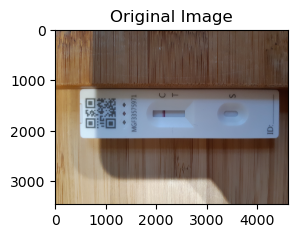

Image  Option 1 data with void/KFT_04.jpg  is too low contrast


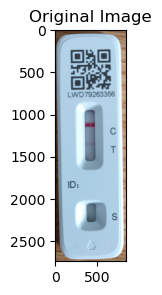

Test result of image  Option 1 data with void/LDT_14.jpg  is:  POSITIVE


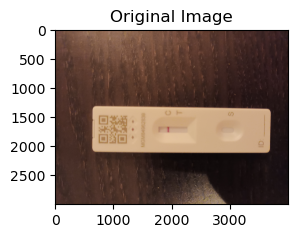

Test result of image  Option 1 data with void/LDR_13.jpg  is:  NEGATIVE


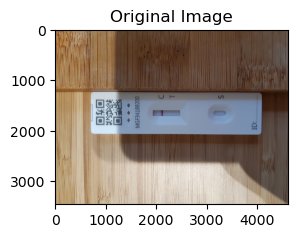

Image  Option 1 data with void/LFT_03.jpg  is too low contrast


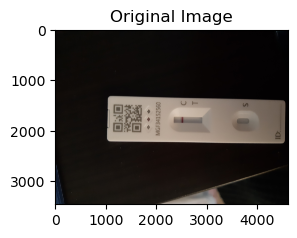

Test result of image  Option 1 data with void/LFT_02.jpg  is:  NEGATIVE


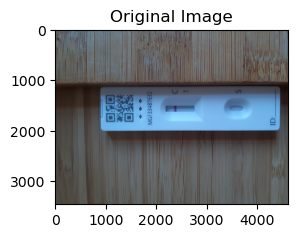

Image  Option 1 data with void/LGT_05.jpg  is too low contrast


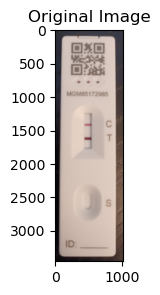

Test result of image  Option 1 data with void/LFT_00.jpg  is:  POSITIVE


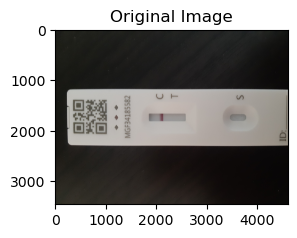

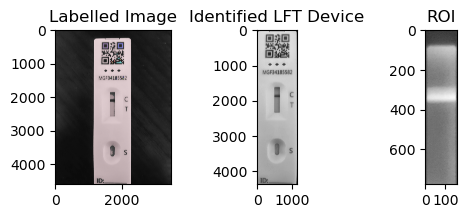

Test result of image  Option 1 data with void/LFT_01.jpg  is:  NEGATIVE


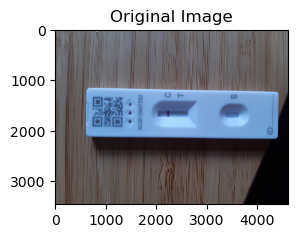

Image  Option 1 data with void/LFT_10.jpg  is too low contrast


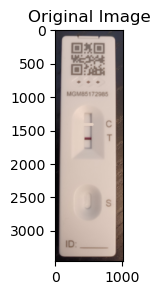

Test result of image  Option 1 data with void/testvoid.jpg  is:  VOID


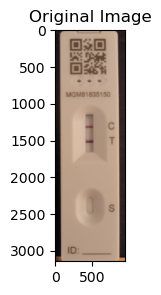

Test result of image  Option 1 data with void/LFT_07.jpg  is:  POSITIVE


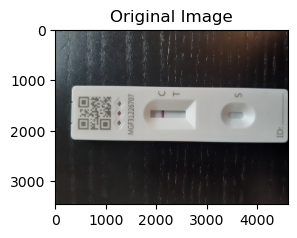

Test result of image  Option 1 data with void/LFT_08.jpg  is:  NEGATIVE


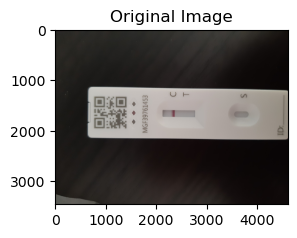

Test result of image  Option 1 data with void/LFY_06.jpg  is:  NEGATIVE


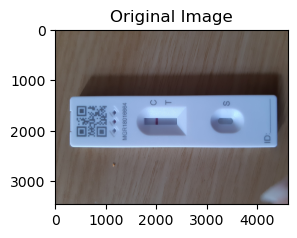

Test result of image  Option 1 data with void/PFT_11.jpg  is:  NEGATIVE
This took:  38.26585793495178 seconds


In [5]:
"""
This cell runs the original pre-processing algorithm for a folder holding the project supplied images with an additional image of a 
void LFT result. The additional image is uploaded with this notebook in Gradescope under the name "testvoid.jpg".
"""
start = time.time()

directory = 'Option 1 data with void' # Set the directory to get input images from 
 
files = Path(directory).glob('*jpg') # Search for all files ending with .jpg

for file in files: # Iterate through all the supplied images

    image = imread(file) # Read in image
    plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.title("Original Image")
    plt.show()
    
    if str(file) == 'Option 1 data with void/LFT_01.jpg': # This if/else statement is just so that the figures of the intermediate 
                                                          # image pre-processing steps shown in the report are displayed
        display_report_images = True
    else:
        display_report_images = False
        
    processedimg = preProcessImageOriginal(image, display_report_images) # Pre-process the image using the original algorithm
    
    if processedimg is None: # This would be the case if the image was rejected due to low contrast (see preProcessImage function)
        print('Image ', str(file),' is too low contrast')
        continue 
    
    testresult = getTestResult(processedimg) # Check the processed image for control and/or test line(s)
    
    print('Test result of image ', str(file),' is: ', testresult)
end = time.time()
print("This took: ", end-start, "seconds")

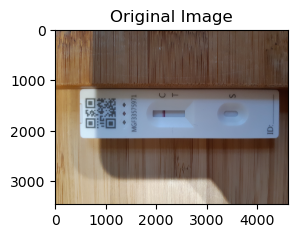

Image  Option 1 data with rotated/KFT_04.jpg  is too low contrast


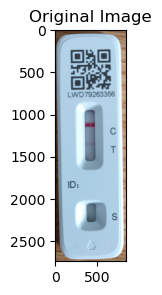

Test result of image  Option 1 data with rotated/LDT_14.jpg  is:  POSITIVE


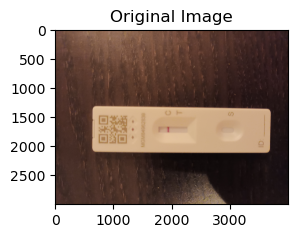

Test result of image  Option 1 data with rotated/LDR_13.jpg  is:  NEGATIVE


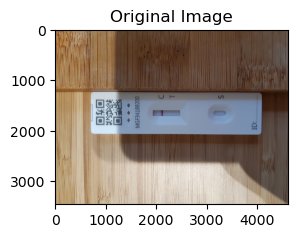

Image  Option 1 data with rotated/LFT_03.jpg  is too low contrast


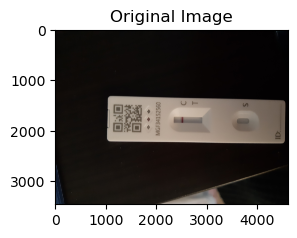

Test result of image  Option 1 data with rotated/LFT_02.jpg  is:  NEGATIVE


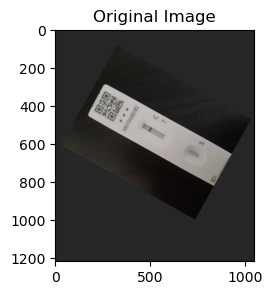

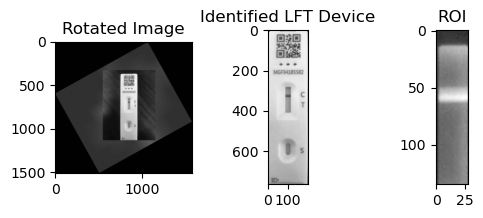

Test result of image  Option 1 data with rotated/testrotated.jpg  is:  NEGATIVE


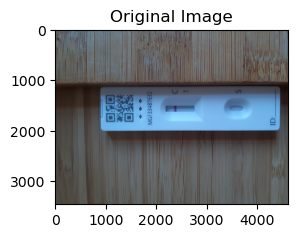

Image  Option 1 data with rotated/LGT_05.jpg  is too low contrast


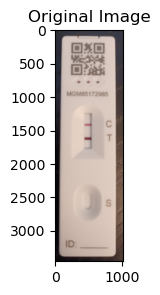

Test result of image  Option 1 data with rotated/LFT_00.jpg  is:  POSITIVE


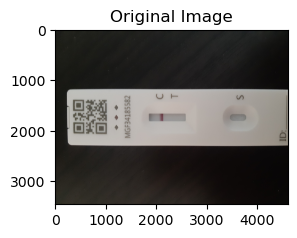

Test result of image  Option 1 data with rotated/LFT_01.jpg  is:  NEGATIVE


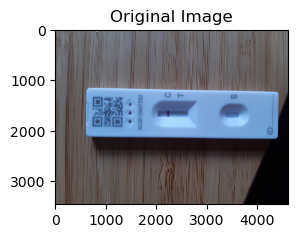

Image  Option 1 data with rotated/LFT_10.jpg  is too low contrast


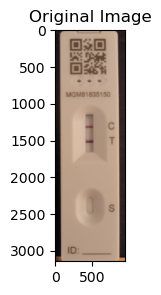

Test result of image  Option 1 data with rotated/LFT_07.jpg  is:  POSITIVE


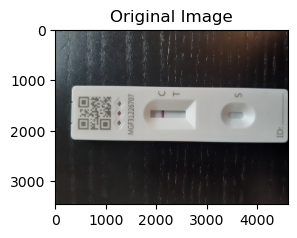

Test result of image  Option 1 data with rotated/LFT_08.jpg  is:  NEGATIVE


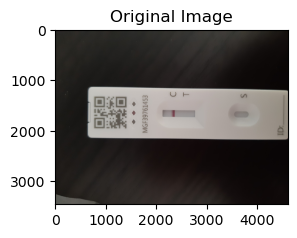

Test result of image  Option 1 data with rotated/LFY_06.jpg  is:  NEGATIVE


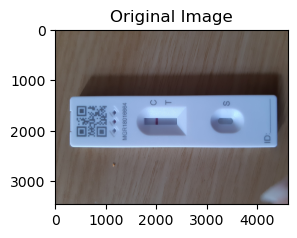

Test result of image  Option 1 data with rotated/PFT_11.jpg  is:  NEGATIVE
This took:  63.154576778411865 seconds


In [6]:
"""
This cell runs the modified pre-processing algorithm for a folder holding the project supplied images with an additional image
of a rotated LFT device. The additional image is uploaded with this notebook in Gradescope under the name "testrotated.jpg".
"""
start = time.time()

directory = 'Option 1 data with rotated' # Set the directory to get input images from 
 
files = Path(directory).glob('*jpg') # Search for all files ending with .jpg

for file in files: # Iterate through all the supplied images

    image = imread(file) # Read in image
    plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.title("Original Image")
    plt.show()
    
    if str(file) == 'Option 1 data with rotated/testrotated.jpg': # This if/else statement is just so that the figures of the intermediate
                                                                  # image pre-processing steps shown in the report are displayed
        display_report_images = True
    else:
        display_report_images = False
        
    processedimg = preProcessImageModified(image, display_report_images) # Pre-process the image using modified algorithm
    
    if processedimg is None: # This would be the case if the image was rejected due to low contrast (see preProcessImage function)
        print('Image ', str(file),' is too low contrast')
        continue 
    
    testresult = getTestResult(processedimg) # Check the processed image for control and/or test line(s)
    
    print('Test result of image ', str(file),' is: ', testresult)
end = time.time()
print("This took: ", end-start, "seconds")